In [56]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as cimg
%matplotlib inline

In [57]:
# Make a list of test images
testImgFolder = './test_images'
testImgPaths = glob.glob(testImgFolder + '/*.jpg')

In [58]:
# Make a list of calibration images
calibratingImgFolder = './camera_cal'
calibratingImgPaths = glob.glob(calibratingImgFolder + '/calibration*.jpg')

In [59]:
#define number of rows and column of the chessboard
n_rows = 6
n_cols = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((n_rows*n_cols,3), np.float32)
objp[:,:2] = np.mgrid[0:n_cols,0:n_rows].T.reshape(-1,2)

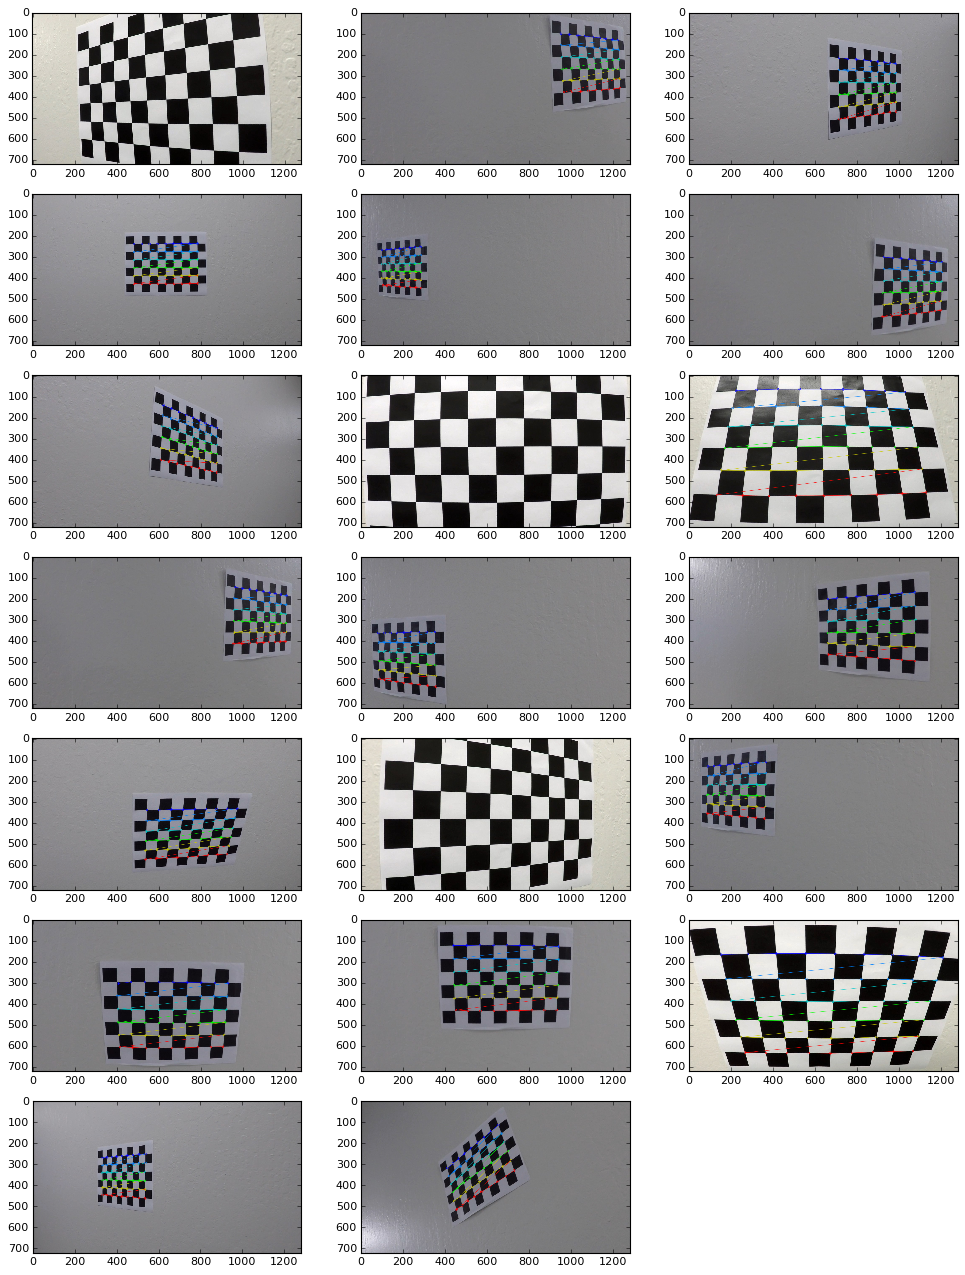

In [60]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
imgSize = []

# Setup plot
plt.figure(1,figsize=(15,20))
idx = 0
plt_cols = 3
plt_rows = len(calibratingImgPaths)/plt_cols + 1

# Step through the list and search for chessboard corners
for fname in calibratingImgPaths:
    img = cimg.imread(fname)
    imgSize = img.shape[0:2]
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (n_cols,n_rows),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (n_cols,n_rows), corners, ret)
        
    plt.subplot(plt_rows, plt_cols, idx+1)
    plt.imshow(img.astype(np.uint8),cmap='gray')
    idx += 1

In [61]:
#compute the camera matrix (mtx) and distortion coefficients (dist):
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSize, None, None)

#Loop all over the raw images and correct their distortion
rawImgs = []
correctedImgs = []
for fname in testImgPaths:
    img = cimg.imread(fname)
    rawImgs.append(img)

    # Correct distortion on raw images
    correctedImg = cv2.undistort(img, mtx, dist, None, mtx)
    correctedImgs.append(correctedImg)

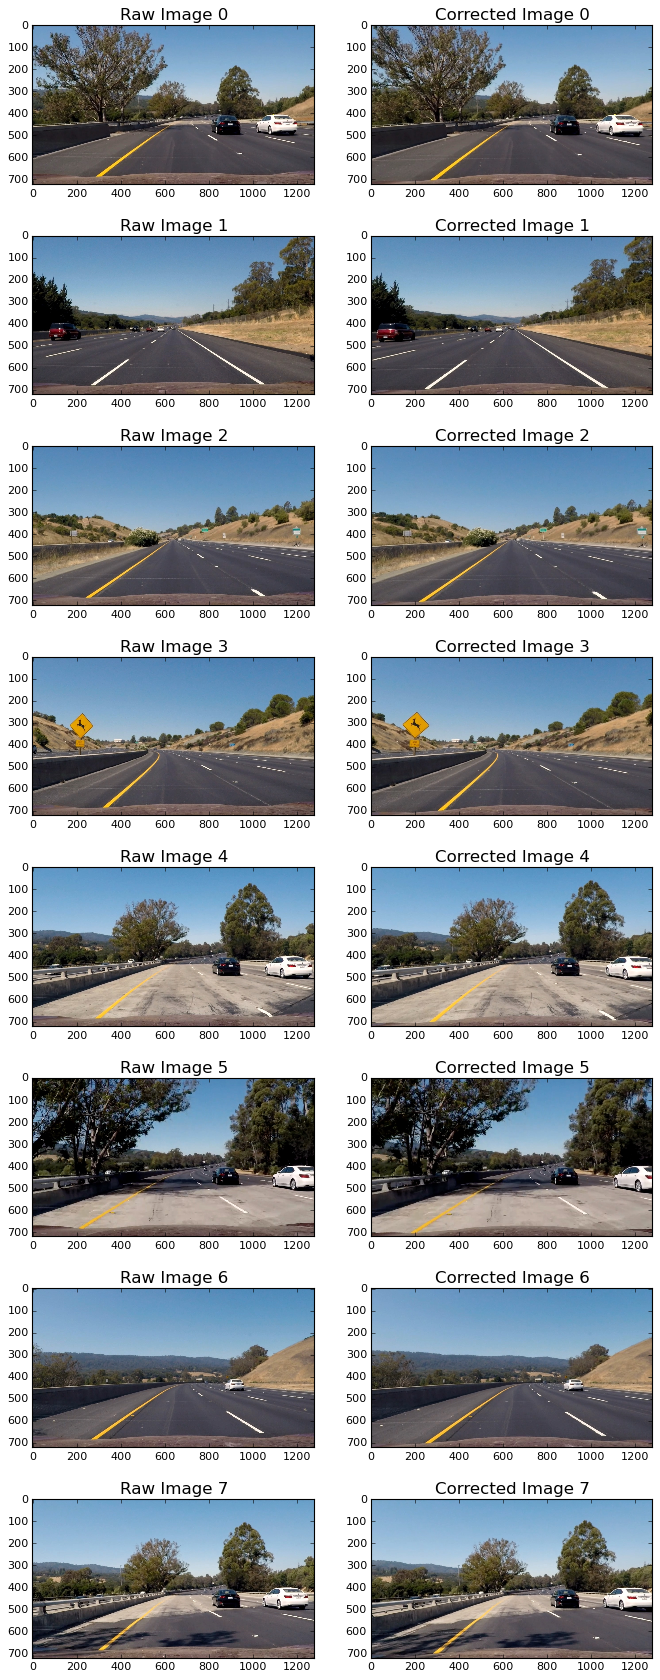

In [62]:
# Setup plot
plt.figure(1,figsize=(10,30))
idx = 0
plt_cols = 2
plt_rows = len(rawImgs)/plt_cols * 2 + 1

for img, correctedImg in zip(rawImgs,correctedImgs):
    #plot image
    plt.subplot(plt_rows, plt_cols, idx+1)
    plt.imshow(img.astype(np.uint8),cmap='gray')
    plt.title('Raw Image {}'.format(idx/2),size=15)
    plt.subplot(plt_rows, plt_cols, idx+2)
    plt.imshow(correctedImg.astype(np.uint8),cmap='gray')
    plt.title('Corrected Image {}'.format(idx/2),size=15)
    idx += 2

In [63]:
#Use color transforms, gradients, etc., to create a thresholded binary image.
def colorAndGradientThreshold(img, s_thresh=(175, 255), sx_thresh=(20, 120)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V and S channels
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    s_channel = hsv[:,:,1]
    # Sobel x
    sobelx = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    binary = sxbinary.astype(np.uint8) | s_binary.astype(np.uint8)
    return color_binary, binary

colorBinaryImgs = []
binaryImgs = []
for correctedImg in correctedImgs:
    colorImg, binImg = colorAndGradientThreshold(correctedImg)
    colorBinaryImgs.append(colorImg)
    binaryImgs.append(binImg)

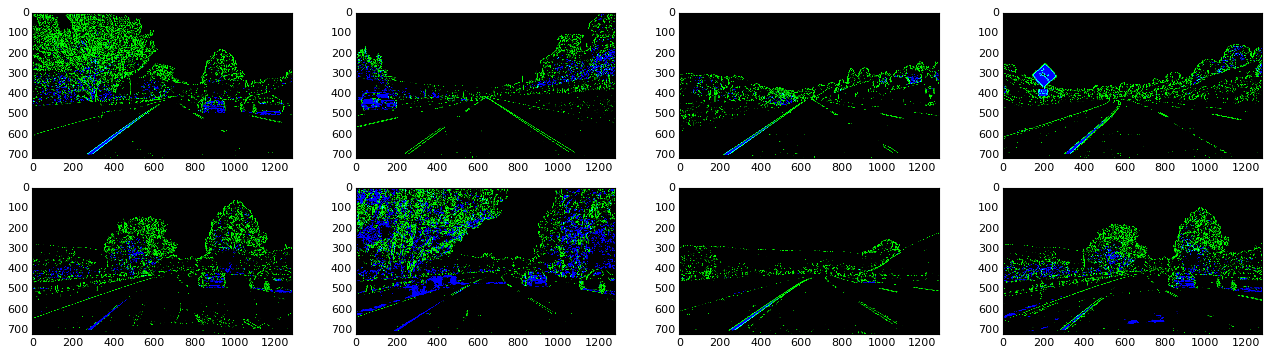

In [64]:
# Setup plot
plt.figure(1,figsize=(20,8))
idx = 0
plt_cols = 4
plt_rows = len(binaryImgs)/plt_cols + 1

for binImg in colorBinaryImgs:
    #plot image
    plt.subplot(plt_rows, plt_cols, idx+1)
    plt.imshow(binImg,cmap='gray')
    idx += 1

(array([594, 450, 217, 720], dtype=int32), array([ 690,  450, 1102,  720], dtype=int32))


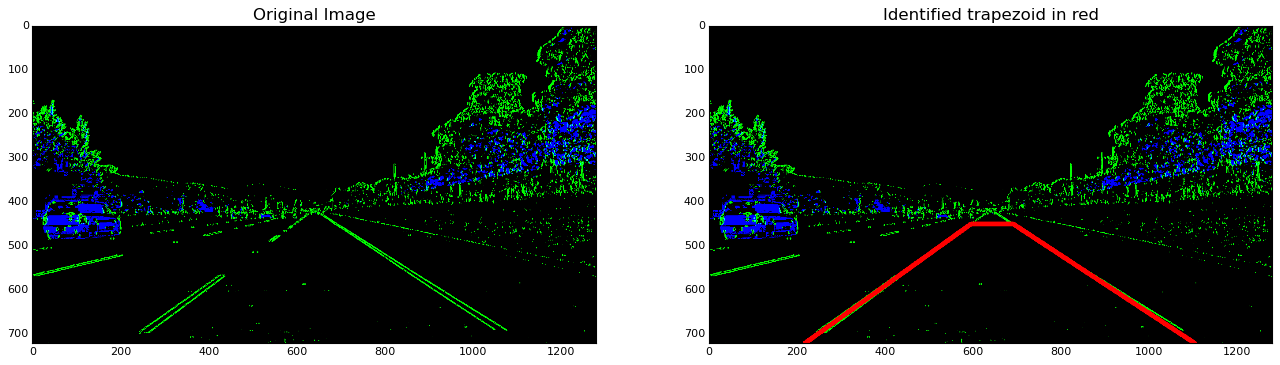

In [65]:
def detectLandlines(edgeImage):
    def region_of_interest(img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (1,) * channel_count
        else:
            ignore_mask_color = 1

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image


    def group_lines(lines, y_min, y_max):
        """Groups the lines based on their median slopes and bias
           Input: lines: list of 2 ends of the line in format of [(x1,y1,x2,y2),(x1,y1,x2,y2),...]
                  y_min, y_max: the 2 bounderies of the output line in y axis
           Return: None if there is no lines else
                   the median line in form of[(x_min, y_min, x_max, y_max)]
        """
        if (len(lines) == 0):
            return None
        else:
            line_slopes = np.float32((lines[:,3] - lines[:,1])) / (np.float32((lines[:,2] - lines[:,0])) + 1e-7)
            slope = np.mean(line_slopes)
            bias = np.mean(lines[:,1] - line_slopes*lines[:,0])
            yy = np.array([y_min,y_max])
            xx = (yy - bias) /  (slope + 1e-7)
            return np.array([xx[0],yy[0],xx[1],yy[1]],dtype=np.int32)

    def filter_left_and_right_lane_lines(imgSize, line_segments):
        """ Filters all of the lane line segments into the 2 left and right lane line
            Input: img: input image
                   line_segments: all the lane line segmentation
            Output: the left and right lane line in form of [(x_left_min,y_left_min),(x_right_min,y_right_min)]
        """
        imgH, imgW = imgSize

        #compute all the slopes of the found line segments
        line_slopes = np.float32((line_segments[:,:,3] - line_segments[:,:,1])) / \
                      (np.float32((line_segments[:,:,2] - line_segments[:,:,0])) + 1e-7)

        #select all the right line segments, whose slopes are from 0.5 to 0.75
        right_line_segments = line_segments[(line_slopes >= 0.5) & (line_slopes <= 0.75)]

        #cluster all the right line segments into single right line
        right_line = group_lines(right_line_segments, 450,imgH )

        #select all the left line segments, whose slopes are from -0.75 to -0.6
        left_line_segments = line_segments[(line_slopes <= -0.6) & (line_slopes >= -0.75)]

        #cluster all the left line segments into single left line
        left_line  = group_lines(left_line_segments,450,imgH )

        if (right_line is not None and left_line is not None):
            return left_line, right_line
        else:
            return None, None


    imgH, imgW = edgeImage.shape[0], edgeImage.shape[1]
    vertices = np.array([[(0,imgH),
                    (550,520),
                    (800,520),
                    (imgW,imgH)
                   ]],dtype = np.int32)

    roiImg = region_of_interest(edgeImage,vertices)

    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    lines = cv2.HoughLinesP(roiImg.astype(np.uint8), rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

    return filter_left_and_right_lane_lines((imgH, imgW),lines)

roiImg = binaryImgs[1].copy()
leftLine, rightLine = detectLandlines(roiImg)
print(leftLine, rightLine)
trapezoidalVertices = np.array([[(leftLine[2],leftLine[3]),
                                (leftLine[0],leftLine[1]),
                                (rightLine[0],rightLine[1]),
                                (rightLine[2],rightLine[3])
                                ]],dtype=np.float32)
#plot trapezoidal images
plt.figure(1,figsize=(20,8))
roiImg = colorBinaryImgs[1].copy()
cv2.polylines(roiImg,trapezoidalVertices.astype(np.int32),isClosed=False,color=(1,0,0),thickness=10)
plt.subplot(1, 2,1)
plt.imshow(colorBinaryImgs[1],cmap='gray')
plt.title('Original Image',size=15)
plt.subplot(1, 2,2)
plt.imshow(roiImg,cmap='gray')
plt.title('Identified trapezoid in red',size=15)

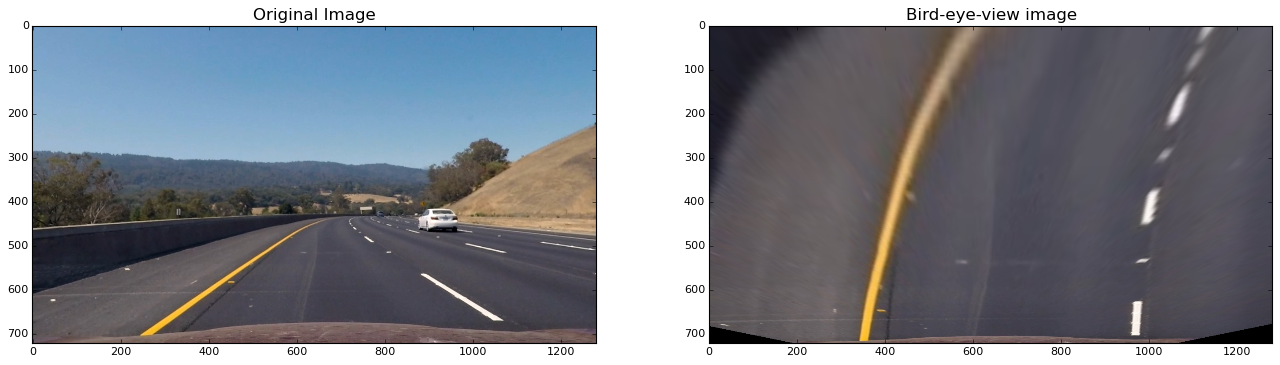

In [72]:
imgH, imgW = imgSize
horizontal_distance_of_2_lanelines_in_birdeye_view = 600 #in pixels
left_laneline_x = imgW/2 - horizontal_distance_of_2_lanelines_in_birdeye_view/2
right_laneline_x = imgW/2 + horizontal_distance_of_2_lanelines_in_birdeye_view/2

bird_eye_vertices = np.array([[(left_laneline_x,imgH),
                                (left_laneline_x,0),
                                (right_laneline_x,0),
                                (right_laneline_x,imgH)
                                ]],dtype=np.float32)
perspectiveTransformMatrix = cv2.getPerspectiveTransform(trapezoidalVertices, bird_eye_vertices)
invPerspectiveTransformMatrix = cv2.getPerspectiveTransform(bird_eye_vertices, trapezoidalVertices)

bird_eye_image = cv2.warpPerspective(correctedImgs[6],perspectiveTransformMatrix, (imgW,imgH), flags=cv2.INTER_LINEAR)

#plot bird_eye_image
plt.figure(1,figsize=(20,8))
plt.subplot(1, 2,1)
plt.imshow(correctedImgs[6],cmap='gray')
plt.title('Original Image',size=15)
plt.subplot(1, 2,2)
plt.imshow(bird_eye_image,cmap='gray')
plt.title('Bird-eye-view image',size=15)

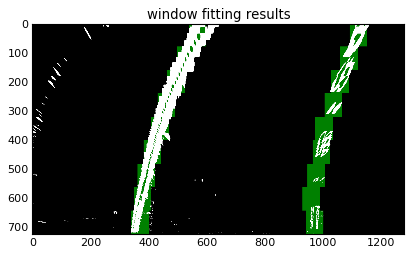

In [73]:
warped = cv2.warpPerspective(binaryImgs[6],perspectiveTransformMatrix, (imgW,imgH), flags=cv2.INTER_LINEAR)
# window settings
window_width = 60 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8)*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 

else: #If no window centers found, just display orginal road image
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)*255

# Display the final results
plt.imshow(output)
plt.title('window fitting results')


In [74]:
def fitPolylineToBinaryImage(img,order=2):
    point_coordinate = np.argwhere(img > 0)
    # Fit a order polynomial to pixel positions in left lane line
    return np.polyfit(point_coordinate[:,0], point_coordinate[:,1], order)
    
left_fit = fitPolylineToBinaryImage(l_points)
right_fit = fitPolylineToBinaryImage(r_points)
print(left_fit, right_fit)
# Define y-value where we want radius of curvature
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(array([  3.02929305e-04,  -5.23156554e-01,   5.84670934e+02]), array([  3.31348773e-04,  -4.84125016e-01,   1.13829399e+03]))


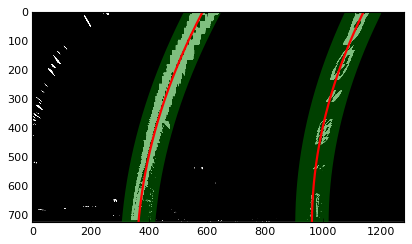

In [75]:
#plotting part
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.imshow(warped,cmap='gray')
plt.plot(left_fitx, ploty, color='green', linewidth=30, alpha=0.5)
plt.plot(right_fitx, ploty, color='green', linewidth=30, alpha=0.5)
plt.plot(left_fitx, ploty, color='red', linewidth=2)
plt.plot(right_fitx, ploty, color='red', linewidth=2)
plt.gca().invert_yaxis() # to visualize as we do the images

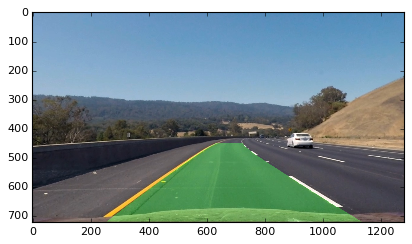

In [76]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, invPerspectiveTransformMatrix, (imgSize[1], imgSize[0])) 
# Combine the result with the original image
result = cv2.addWeighted(correctedImgs[6], 1, newwarp, 0.3, 0)
plt.imshow(result)

In [130]:
#Curvature in pixel
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

(1669.5611246089568, 1509.1163178895572)


In [133]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30./720. # meters per pixel in y dimension
ym = (ploty.astype(np.float)*ym_per_pix).reshape(-1)
y_eval = ym.max()

xm_per_pix = 3.7/horizontal_distance_of_2_lanelines_in_birdeye_view # meters per pixel in x dimension
xm_left = left_fitx*xm_per_pix
xm_right = right_fitx*xm_per_pix

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ym,xm_left, 2)
right_fit_cr = np.polyfit(ym,xm_right, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
radius_of_curvature = (left_curverad + right_curverad)/2.
print "The radius of curvature = {:.1f}(m)".format(radius_of_curvature)

# center of the land
center_of_car_wrt_center_of_lane = (( imgW - right_fitx[-1] - left_fitx[-1]) / 2.)*xm_per_pix
if (center_of_car_wrt_center_of_lane > 0):
    print "The vehicle is {:.3f} right of the center".format(center_of_car_wrt_center_of_lane)
else:
    print "The vehicle is {:.3f}m left of the center".format(-center_of_car_wrt_center_of_lane)

The radius of curvature = 448.2(m)
The vehicle is 0.144m left of the center


In [128]:
xm_per_pix

0.006166666666666667